<a href="https://colab.research.google.com/github/shunitavni/Fashion-MNIST-CNN/blob/master/Fashion_MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CNN over Fasion MNIST**

In this notebook I build a convolutional network and train it over the Fasion MNIST data, which is a collection of 28X28 black and white images, classified into 10 different classes of clothing items. For more information about Fashion MNIST you may refer to: 
https://github.com/zalandoresearch/fashion-mnist 

In [ ]:
# Loading Fashion MNIST


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from google.colab import files

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [ ]:
# Use dataloaders for train and test (batch size is 4)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

In [ ]:
# The images are of 1, 28, 28 size (only one black-white channel)

trainset[0][0].shape
print(len(testloader.dataset))

10000



following architecture:

* Convolution with 10 3X3 filters
* Relu
* Max pool with 2X2
* Convolution with 5 3X3 filters
* Relu
* Convolution with 16 3X3 filters
* Relu
* Max pool with 2X2
* Liner, output size 128
* Relu
* Liner, output size 64
* Relu
* Liner, output size 10

In [ ]:
class CNNFMnist(nn.Module):

   def __init__(self):
        super(CNNFMnist, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.conv2 = nn.Conv2d(10, 5, 3)
        self.conv3 = nn.Conv2d(5, 16, 3)

        # now a few fully connected layers
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
   def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
    
   def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension [16,4,4]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [ ]:
#net = CNNFMnist().cuda()     # -- For GPU
net = CNNFMnist()             # -- For CPU

print(net)

CNNFMnist(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


Write a code that trains the network with FashionMNIST train dataset, for classification (use cross entropy, and SGD).
Run the network for at least 10 epochs, over the entire dataset.
Printed the loss over the train set as well as the **test set** over time (say, every 1000 batches, but it's up to you), so you will know where you are during training. 

Note, measuring loss of test is similar to measuring loss over the train test. However, make sure not to run the test images in back propagation. Use them only in forward and calulate the average loss over the entire test set. Since it will make the training process run slower, you should measure loss for the test set only at the end of an epoch (so overall you get 10 loss values for the test set).


collecting the loss values in an array, and then plot them into two curves, one for train and one for test.

In addition, measured the time it takes you to train the network completely.



In [ ]:
# define loss function

criterion = nn.CrossEntropyLoss()

In [ ]:
# define the optimizer

optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#for test set
def calculate_loss():
    test_loss = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs
        inputs, labels = data
        
       # inputs = inputs.cuda() # -- For GPU
       #labels = labels.cuda() # -- For GPU

        # forward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # print statistics
        test_loss += loss.item()
    
    return (test_loss/ len(testloader))

In [ ]:
# train loop
train_loss_arr = []
test_loss_arr = []
temp_loss_arr=0.0

start_time = time.time()
for epoch in range(10):  

    running_loss = 0.0
    temp_loss_arr=0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data 
        
        #inputs = inputs.cuda() # -- For GPU
        #labels = labels.cuda() # -- For GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimizer
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        temp_loss_arr +=  loss.item()
        if (i+1) % 1000 == 0:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    test_loss_arr.append(calculate_loss())
    train_loss_arr.append(temp_loss_arr / (i+1) )
print('Finished Training')
print('train loss arr:', train_loss_arr)
print('test loss arr:', test_loss_arr )

finish_time = time.time()
train_time = finish_time - start_time
print('Total Training Time Is: %.3f seconds' % train_time)

this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Size([16, 4, 4])
this is me: torch.Si

KeyboardInterrupt: ignored

In [ ]:
x = calculate_loss()
print(x)

0.34438757065137526


In [ ]:
print(train_time)

611.6379556655884


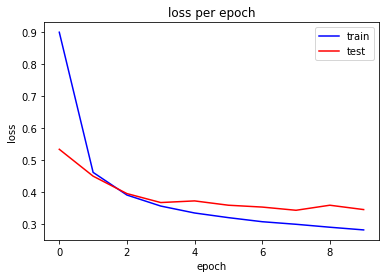

In [ ]:
x = np.arange(0,10)
f = plt.figure()
plt.plot(x, train_loss_arr,label = 'train',c='blue')
plt.plot(x, test_loss_arr,label = 'test',c='red')
plt.title('loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
f.show()




Write a function that evaluates the resulted model over the entire test data of FashionMNIST. Provide a single accuracy number.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data 
        #images = images.cuda()  # -- for GPU
        #labels = labels.cuda()  # -- for GPU

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 88 %
